In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import mpld3
import matplotlib.animation as animation
from IPython import display

#%matplotlib widget

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Experiment Directed Simulation

*Johannes Margraf*

Experiment Directed Simulation (EDS) is a method that allows biasing atomistic simulations so that certain observables (e.g. densities or moments of radial distribution functions) match experimental observations. This is achieved by adding a bias to the simulation, which minimally distorts the original Boltzmann distribution. For details, have a look at the original paper by [White and Voth](https://pubs.acs.org/doi/full/10.1021/ct500320c). In this notebook we implement EDS from scratch and use it to bias Monte Carlo simulations on a one dimensional potential energy surface (PES).

We begin by defining a potential energy surface as a simple double-well potential. This will represent our basic interatomic potential method:

In [2]:
class PES:
    def __init__(self,g,asym=0.0):
        self.g = g
        self.asym=asym
    def potential(self,x):    
        return x**2*(1.-self.g*x)**2+self.asym*x

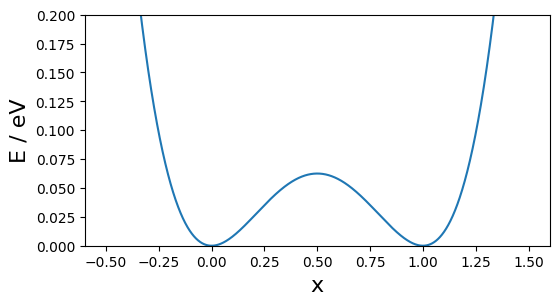

In [4]:
fig = plt.figure(figsize=(6, 3), dpi=100)
x = np.linspace(-0.5,1.5,2000)
pes = PES(1.0)
plt.plot(x,pes.potential(x))
plt.ylim([0,0.2])
plt.xlabel('x',fontsize=16)
plt.ylabel('E / eV',fontsize=16)
plt.show()

#html = fig.HTML(video)
#display.display(html) 

#plt.savefig('original_potential.png',bbox_inches='tight')

Now we define a Markov Chain Monte Carlo code to sample the equilibrium distribution ($P(x)$) of positions $x$, which corresponds to this pontential energy surface $U(x)$:

In [5]:
class MCMC:
    def __init__(self,x0=2,Temperature=300,stepsize=0.1):
        self.x0 = x0
        self.Temperature = Temperature
        self.stepsize = stepsize
        self.kbT = 8.617333262E-5*Temperature
        self.xold = x0    
        
    def run(self,potential,nsteps=200000,burnin=0.2):
        self.Eold = potential(self.xold)
        step0 = int(burnin*nsteps)
        x_traj = [self.xold]
        E_traj = [self.Eold]
        accepted = 0
        rejected = 0
        
        for i in range(nsteps):
            #step 
            step = self.stepsize*np.random.randn()  
            xnew = self.xold+step  #min(max(xold+step,0),1999)
            Enew = potential(xnew)
            #metropolis
            if Enew<self.Eold or np.exp(-(Enew-self.Eold)/self.kbT)>np.random.rand():
                x_traj.append(xnew)
                E_traj.append(Enew)
                self.xold = xnew
                self.Eold = Enew
                accepted += 1
            else:
                x_traj.append(self.xold)
                E_traj.append(self.Eold)
                self.xold = self.xold
                self.Eold = self.Eold
                rejected += 1
        print("acceptance ratio=",accepted/(rejected+accepted))
        return x_traj[step0:], E_traj[step0:]
    

This is written as a class, so that we can take a given number of MC steps and the restart from the same place in a simple fashion. Let's see how this works by running an equilibration trajectory and then a production run. Note that technically the equilibration can also be done with the `burnin` keyword which discards a fraction of the trajectory. 

acceptance ratio= 0.774396
acceptance ratio= 0.77563


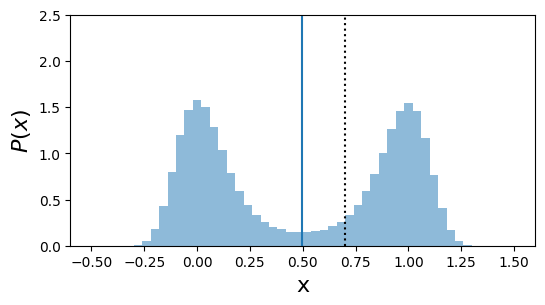

In [6]:
pes     = PES(1.0)
T       = 300
N_iter  = 500000
MC_obj  = MCMC(x0=0.5,stepsize=0.1,Temperature=T)
MC_eq   = MC_obj.run(pes.potential,nsteps=10*N_iter,burnin=0.2)
MC_prod = MC_obj.run(pes.potential,nsteps=N_iter,burnin=0.0)

plt.figure(figsize=(6, 3), dpi=100)

plt.hist(MC_prod[0],density=True,bins=50,range=[-0.5,1.5],alpha=0.5)
plt.axvline(np.mean(MC_prod[0]))
plt.axvline(0.7,color='k',linestyle=':')

plt.xlabel('x',fontsize=16)
plt.ylabel('$P(x)$',fontsize=16)

plt.ylim([0.0,2.5])

#plt.savefig('original_distribution.png',bbox_inches='tight')
plt.show()

As expected, the equilibrium distribution is bimodal and symmetric, with a mean value of 0.5. Now, let's assume that we know from experiments that the true mean is 0.7. Can we modify our potential energy surface so that the simulated distribution reflects this? Of course we can. For example, we could add a strong harmonic restraint that forces $x$ to be close to 0.7 at all times. However, this is a strong modification of the PES and the resulting distribution will look nothing like the one shown above. So let's refine this question a bit: What is the smallest possible bias that will modify the PES in such a way that the mean of the distribution becomes 0.7? This question is answered by the Experiment Directed Simulation (EDS) approach. 

Briefly, it can be shown that the minimal bias is linear in the collective variable that defines the observable. For each observable that we are biasing towards we thus only need to determine a coupling constant $\alpha$. The value of this constant is learned by a form of stochastic gradient during the course of the simulation.

Here's a simple implementation of EDS:

In [7]:
class bias_eds:
    def __init__(self,alpha,target,potential):
        self.alpha  = alpha
        self.target = target
        self.potential = potential
    def biased_potential(self,x):
        return self.alpha*x/self.target + self.potential(x)  

class bias_harmonic:
    def __init__(self,k,target,potential):
        self.k = k
        self.target = target
        self.potential = potential
    def biased_potential(self,x):
        return self.k*(x-self.target)**2 + self.potential(x)

def EDS(potential,MC_obj,target_x,A=0.1,N_inner=100000,N_outer=10,max_step=0.1):
    alpha = 0.0
    beta = 1./MC_obj.kbT
    grads = []
    trajs = []
    alphas = [alpha]
    for i_outer in range(N_outer):
        bias = bias_eds(alpha,target_x,potential)
        MC = MC_obj.run(bias.biased_potential,nsteps=N_inner,burnin=0.0)
        #MC = MC_obj.run(potential,nsteps=N_iter,burnin=0.0)
        trajs.append(MC[0])
        current_x = np.mean(MC[0])
        sq_curr_x = np.mean(np.array(MC[0])**2)
        grad_alpha = 2.*beta*(current_x/target_x-1.)*(current_x**2-sq_curr_x)
        grads.append(grad_alpha)
        sum_grads = np.sum(np.array(grads)**2)
        learning_rate = A/sum_grads
        alpha += -learning_rate*grad_alpha
        alphas.append(alpha)
    return trajs,alphas        


There's a number of hyperparameters to EDS. The constant `A` (in energy units) defines the maximum stepsize that the algorithm uses to update the simulation. The value used below is quite small to show a gradual transition between the unbiased and biased simulations. We update $\alpha$ every `N_inner` steps. This value should be large enough to get a reasonably precise average of our target observable. Finally, `N_outer` defines the number of updates that are made.

Let's run this:

In [8]:
trajs,alphas = EDS(pes.potential,MC_obj,0.7,A=0.025,N_inner=N_iter,N_outer=20)

acceptance ratio= 0.774458
acceptance ratio= 0.77401
acceptance ratio= 0.773448
acceptance ratio= 0.77261
acceptance ratio= 0.771922
acceptance ratio= 0.772764
acceptance ratio= 0.771882
acceptance ratio= 0.772172
acceptance ratio= 0.771252
acceptance ratio= 0.77168
acceptance ratio= 0.77065
acceptance ratio= 0.771724
acceptance ratio= 0.771226
acceptance ratio= 0.771816
acceptance ratio= 0.769928
acceptance ratio= 0.770032
acceptance ratio= 0.771576
acceptance ratio= 0.769676
acceptance ratio= 0.768614
acceptance ratio= 0.770078


Next we can make some animations to understand the results. First, let's look at how the mean changes in the course of the simulation:

In [9]:
centers = []
means = []

MC_col = []
step_col = []

plotstep = 5000

limits = int(N_iter/plotstep)

#step_0 = list(np.linspace((0)*N_iter,(0+1)*N_iter,N_iter)[::plotstep])
#MC_0   = trajs[0][1::plotstep]

for i,MC in enumerate(trajs):
    #MC = trajs[i]
    step_temp = list(np.linspace((i)*N_iter,(i+1)*N_iter,N_iter))
    MC_col += MC[1::plotstep]
    step_col += step_temp[::plotstep]
    means.append(np.mean(MC))
    centers.append((i)*N_iter+0.5*N_iter)

fig, ax = plt.subplots(figsize=(6, 3), dpi=100)

#x = np.arange(0, 2*np.pi, 0.01)
meansline = ax.plot(centers[0], means[0],c='k')
mcline = ax.plot(step_col[0:limits],MC_col[0:limits],alpha=0.1)

lines = [mcline[0],meansline[0]]

ax.axhline(0.5,color='k',linestyle=':')
ax.axhline(0.7,linestyle=':',color='k')

ax.set_xlabel('Simulation Step',fontsize=16)
ax.set_ylabel('Mean x',fontsize=16)
ax.set_xticks([0,2e6,4e6,6e6,8e6,1e7],[r'$0$',r'$2 \times 10^6$',r'$4 \times 10^6$',r'$6 \times 10^6$',r'$8 \times 10^6$',r'$1 \times 10^7$'])
ax.set_xlim([0,1e7])
ax.set_ylim([-0.2,1.2])

#plt.show()

#for i,MC in enumerate(trajs):

#def gen_function():

def update(i):
    #print(lines)
    #lines[0].set_xdata(step_col[(i+1)*limits,(i+2)*limits])
    #lines[0].set_ydata(MC_col[(i+1)*limits,(i+2)*limits])
    
    #lines[1].set_xdata(centers[:i+1])
    #lines[1].set_ydata(means[:i+1])
    lines[0].set_xdata(step_col[(0)*limits:(i+1)*limits])
    lines[0].set_ydata(MC_col[(0)*limits:(i+1)*limits])
    
    lines[1].set_xdata(centers[:i+1])
    lines[1].set_ydata(means[:i+1])
    return lines
    #plt.show()

plt.tight_layout()
anim = animation.FuncAnimation(fig, update, interval=1000,save_count=20)
#anim.to_jshtml()
#anim.save('animation.mp4', fps=1)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close() 




And here are the initial and final distributions and means plotted as histograms:

Text(0, 0.5, '$P(x)$')

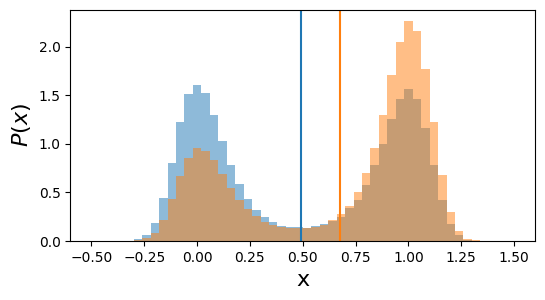

In [10]:
plt.figure(figsize=(6, 3), dpi=100)

plt.hist(trajs[0],density=True,bins=50,range=[-0.5,1.5],alpha=0.5)
plt.hist(trajs[-1],density=True,bins=50,range=[-0.5,1.5],alpha=0.5)
#plt.hist(MCs[-1],density=True,bins=50,range=[-0.5,1.5],alpha=0.5)

plt.axvline(np.mean(trajs[0]),color=colors[0])
plt.axvline(np.mean(trajs[-1]),color=colors[1])

plt.xlabel('x',fontsize=16)
plt.ylabel('$P(x)$',fontsize=16)

Actually, we can also animate this:

In [13]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=100)

#plt.hist(MCs[-1],density=True,bins=50,range=[-0.5,1.5],alpha=0.5)

ax.axvline(0.7,color='k',linestyle=':')

ax.axvline(np.mean(trajs[0]),color=colors[0])
vline = ax.axvline(np.mean(trajs[1]),color=colors[1])

ax.set_xlabel('x',fontsize=16)
ax.set_ylabel('$P(x)$',fontsize=16)

ax.set_ylim([0,2.5])

HIST_BINS = np.linspace(-0.5, 1.5, 50)


_, _, bar_container = ax.hist(trajs[0],density=True,bins=HIST_BINS,alpha=0.5)
_, _, bar_container_up = ax.hist(trajs[1],density=True,bins=HIST_BINS,alpha=0.5)


plt.tight_layout()

def prepare_animation(bar_container_up,vline):

    def animate(frame_number):
        n, _ = np.histogram(trajs[frame_number], HIST_BINS,density=True)
        mean = np.mean(trajs[frame_number])
        for count, rect in zip(n, bar_container_up.patches):
            rect.set_height(count)
        vline.set(data=np.array([[mean,mean],[0.0,2.5]]))#= ax.axvline(np.mean(trajs[frame_number]),color=colors[1])
        #print(bar_container_up.patches)
        sequence = [patch for patch in bar_container_up.patches]
        sequence.append(vline)
        return sequence
    return animate

#anim = animation.FuncAnimation(fig, update, interval=1000,save_count=20)
ani = animation.FuncAnimation(fig, prepare_animation(bar_container_up,vline), 20,
                              repeat=False, blit=True)

#ani.save('animation_histogram.mp4', fps=1)

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

We can see that the distribution is changed only slightly: It's still bimodal and the maxima are at the same location. Here is how the biased potential evolves:

In [14]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=100)

x = np.linspace(-0.5,1.5,2000)
pes = PES(1.0)

bias = bias_eds(alphas[0],0.7,pes.potential)
ax.plot(x,pes.potential(x))
line = ax.plot(x,bias.biased_potential(x))

def update(i):
    bias = bias_eds(alphas[i],0.7,pes.potential)
    line[0].set_ydata(bias.biased_potential(x))
    return line
    #plt.show()


ax.set_ylim([-0.05,0.2])
ax.set_xlabel('x',fontsize=16)
ax.set_ylabel('E / eV',fontsize=16)
plt.tight_layout()

anim = animation.FuncAnimation(fig, update, interval=1000,save_count=20)

#anim.save('animation_potential.mp4', fps=1)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

